In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 加载数据 

In [2]:
train = pd.read_csv("./train_dataset.csv")
test = pd.read_csv("./test_dataset.csv")

In [3]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [3]:
train.shape

(38984, 23)

# 描述性统计

In [14]:
features_columns = train.drop(["smoking"], axis=1)

# 筛选出数值型变量和分类型变量
numeric_variables = []
categorical_variables = []
for column in features_columns.columns:
    if features_columns[column].nunique() <= 10:
        categorical_variables.append(column)
    else:
        numeric_variables.append(column)

numeric_features = features_columns[numeric_variables]
categorical_features = features_columns[categorical_variables]

## 数值型变量

In [15]:
features_columns[numeric_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
age,38984.0,44.127591,12.063564,20.0,40.0,40.0,55.0,85.0
height(cm),38984.0,164.689488,9.187507,130.0,160.0,165.0,170.0,190.0
weight(kg),38984.0,65.938718,12.896581,30.0,55.0,65.0,75.0,135.0
waist(cm),38984.0,82.062115,9.326798,51.0,76.0,82.0,88.0,129.0
eyesight(left),38984.0,1.014955,0.498527,0.1,0.8,1.0,1.2,9.9
eyesight(right),38984.0,1.008768,0.493813,0.1,0.8,1.0,1.2,9.9
systolic,38984.0,121.475631,13.643521,71.0,112.0,120.0,130.0,233.0
relaxation,38984.0,75.994408,9.658734,40.0,70.0,76.0,82.0,146.0
fasting blood sugar,38984.0,99.342269,20.642741,46.0,89.0,96.0,104.0,423.0
Cholesterol,38984.0,196.883491,36.353945,55.0,172.0,195.0,219.0,445.0


## 分类型变量

In [16]:
features_columns[categorical_variables].astype("category").describe()

,hearing(left),hearing(right),Urine protein,dental caries
count,38984,38984,38984,38984
unique,2,2,6,2
top,1,1,1,0
freq,37995,37963,36836,30625


https://www.kaggle.com/code/kumudithasilva/ps-s3e24-bio-signals-eda-pca-shap?scriptVersionId=150513479&cellId=9

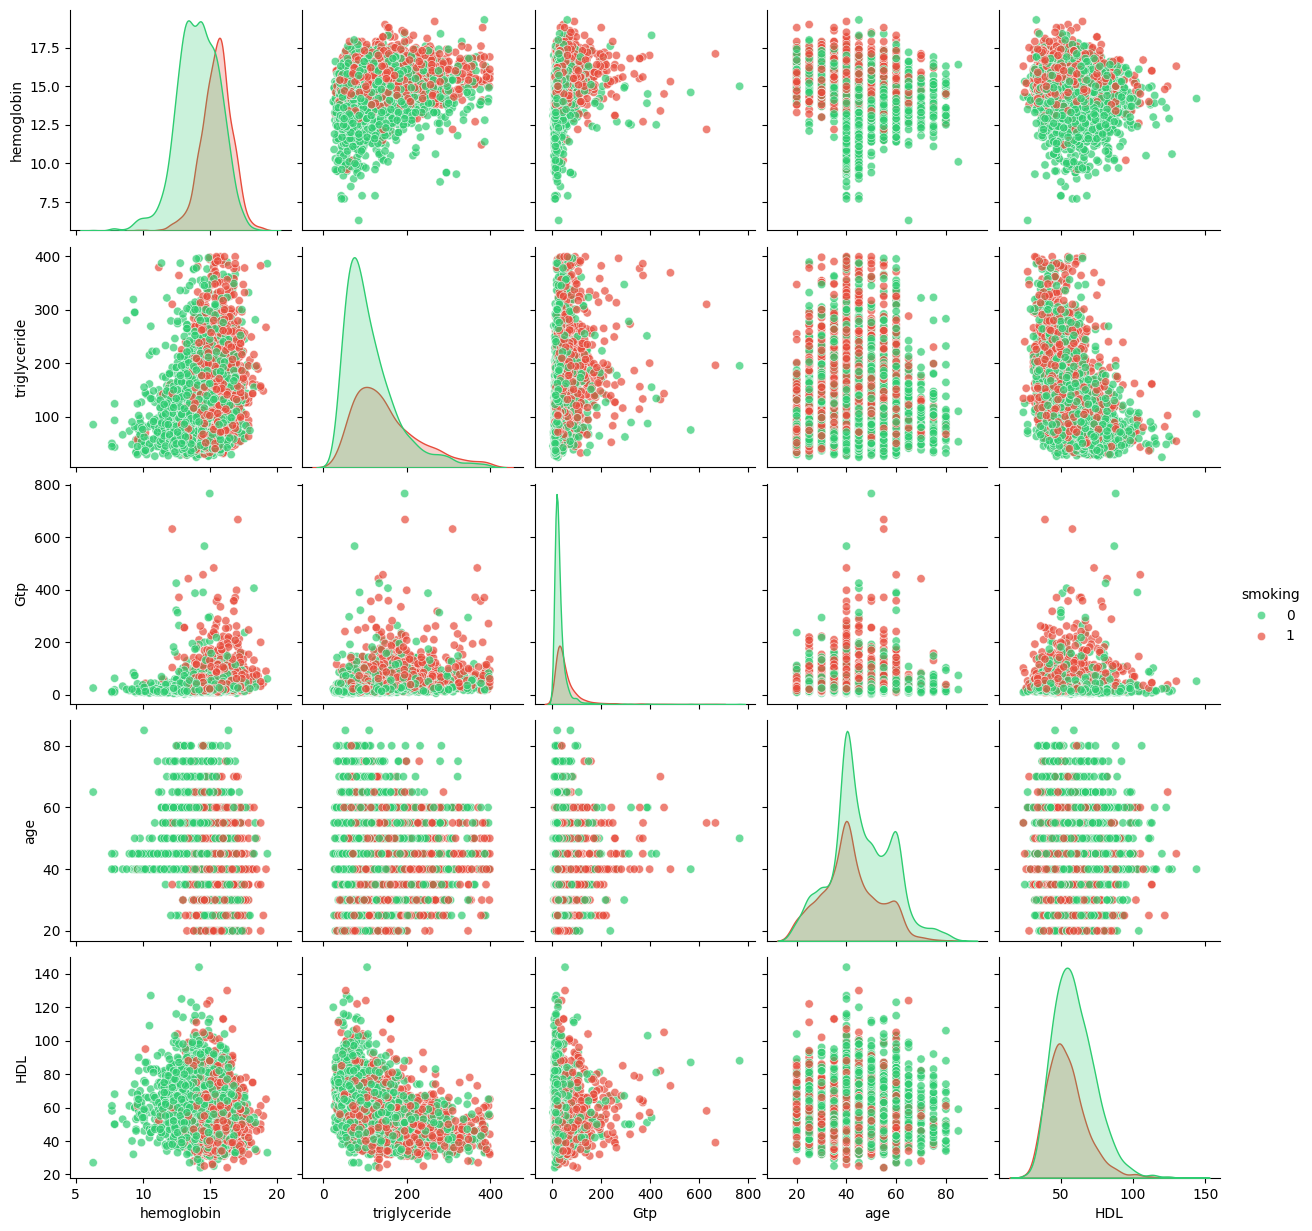

In [35]:
colors = ["#2ecc71", "#e74c3c"]  # Red for smokers, Green for non-smokers

subset_data = train[['hemoglobin', 'triglyceride', 'Gtp',
                     'age', 'HDL', 'smoking']].sample(frac=0.1, random_state=1)

# Recreate the pair plot
pair_plot = sns.pairplot(subset_data, hue='smoking',
                         palette=colors, plot_kws={'alpha': 0.7})

plt.show()

Hemoglobin vs. Age:

A visible trend where younger individuals, especially smokers, tend to have higher hemoglobin levels.
While the distinction between smokers and non-smokers is not stark, there's a tendency for smokers to have higher hemoglobin levels across ages.
Triglyceride vs. Age:

Triglyceride levels appear to be higher in smokers across different age groups.
Despite some overlap, there's a slight tendency for younger smokers to have higher triglyceride levels.
Gtp vs. Age:

Higher levels of Gtp are observed in smokers across all ages, with some outliers showing particularly high levels.
This might indicate liver stress or other related health issues associated with smoking.
BMI vs. Age:

BMI does not show a clear distinction between smokers and non-smokers with respect to age.
Both groups are distributed across a similar range of BMI values, but there are smokers with high BMI values across all ages.

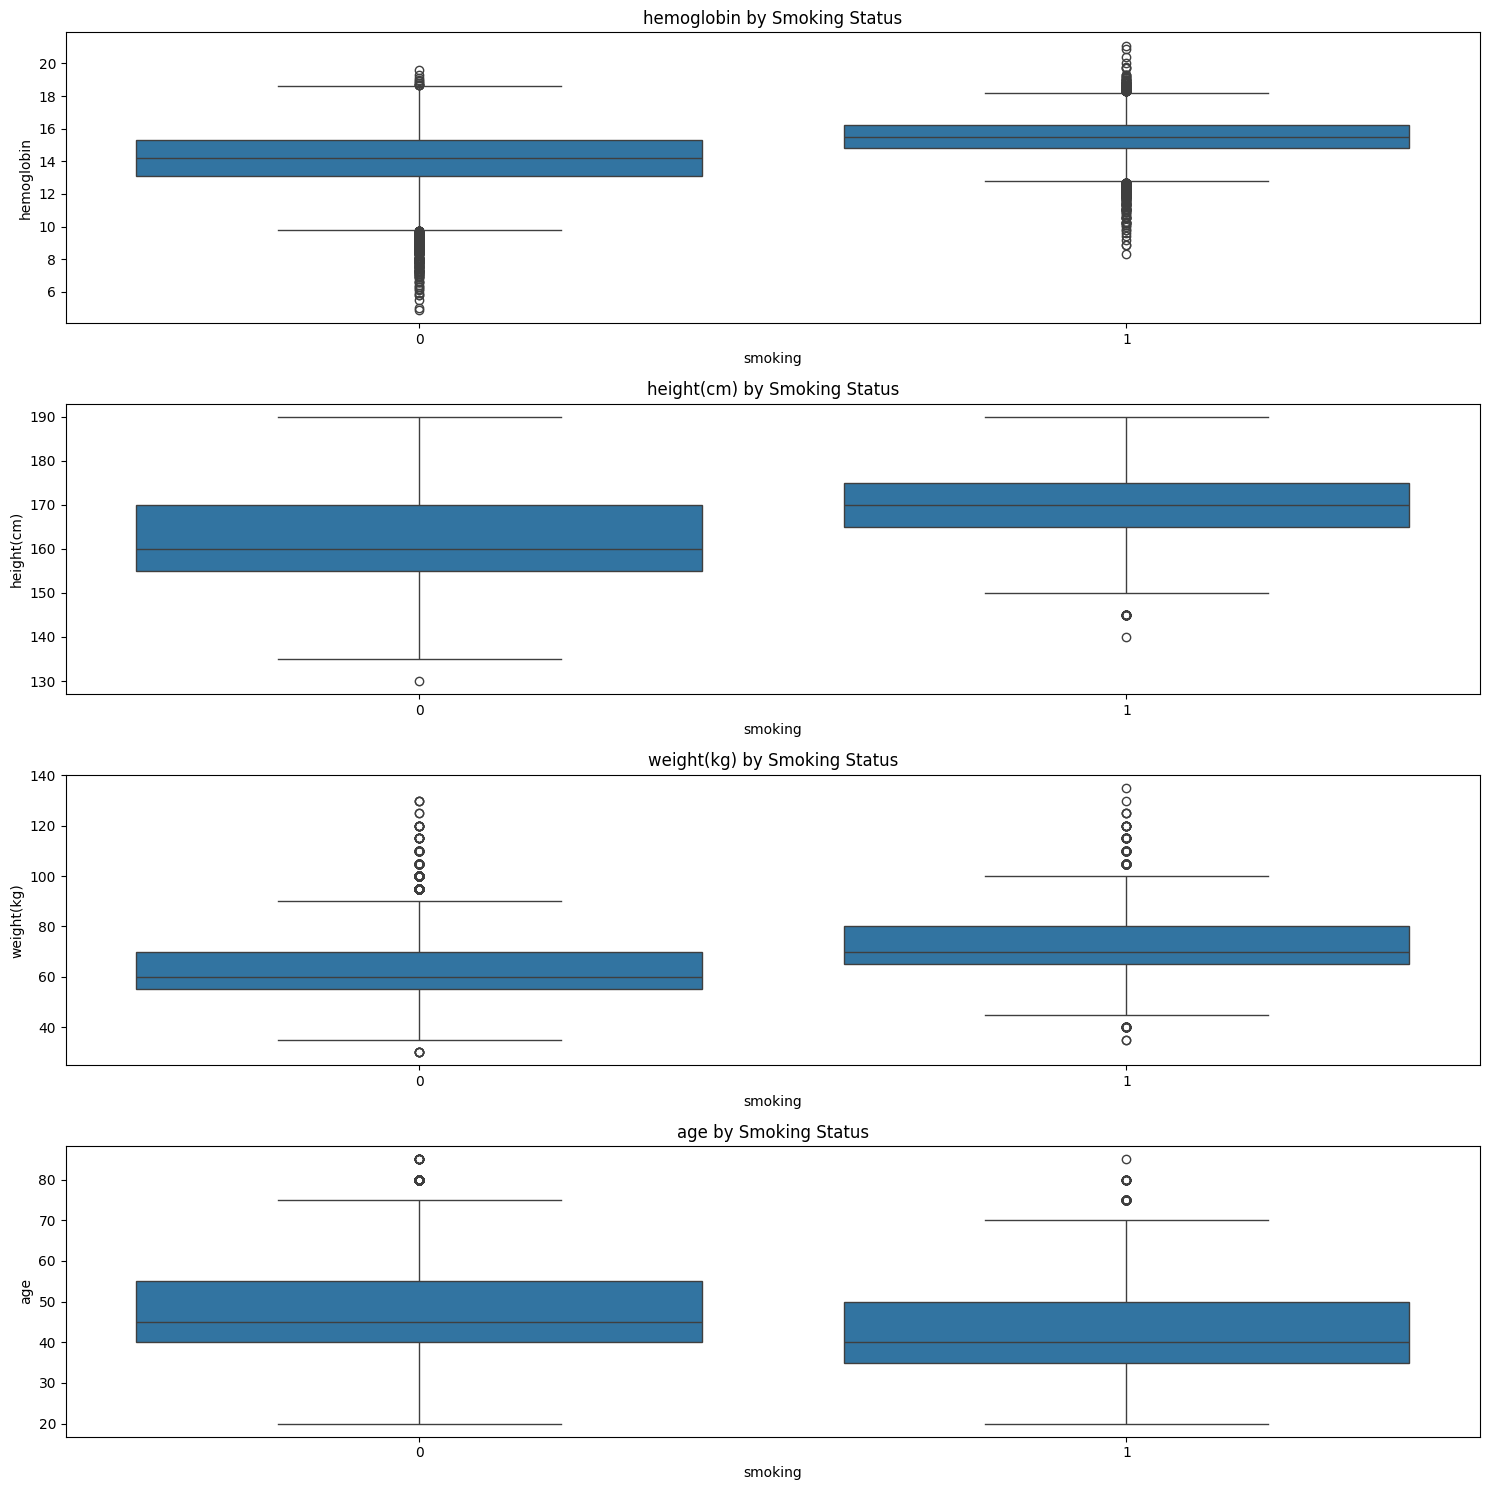

Mean             Median       
smoking              0           1      0      1
hemoglobin   14.145423   15.449176   14.2   15.5
height(cm)  161.929376  169.444406  160.0  170.0
weight(kg)   62.997446   71.005727   60.0   70.0
age          45.655761   41.494971   45.0   40.0

In [28]:
# Group the data by 'smoking' and calculate the mean for each feature
mean_features_by_smoking = train.groupby('smoking').mean().transpose()

# Calculate the median for each feature as well
median_features_by_smoking = train.groupby('smoking').median().transpose()

# Combine the mean and median dataframes
summary_by_smoking = pd.concat([mean_features_by_smoking, median_features_by_smoking],
                               keys=['Mean', 'Median'], axis=1)

# Now, let's visualize the distribution of some key features with respect to the smoking status using box plots
# Selecting a subset of features that may have interesting differences
features_to_visualize = ['hemoglobin', 'height(cm)', 'weight(kg)', 'age',]

num_features = len(features_to_visualize)
plt.figure(figsize=(15, 15))

for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(num_features, 1, i)
    sns.boxplot(x='smoking', y=feature, data=train)
    plt.title(f'{feature} by Smoking Status')

plt.tight_layout()
plt.show()

summary_by_smoking.loc[features_to_visualize]

# 探索性数据分析 

In [4]:
# 探查数据集样本量及特征数量

m, n = train.shape
print('Number of rows in dataset : ', m)
print('Number of columns in dataset : ', n)

Number of rows in dataset :  38984
Number of columns in dataset :  23


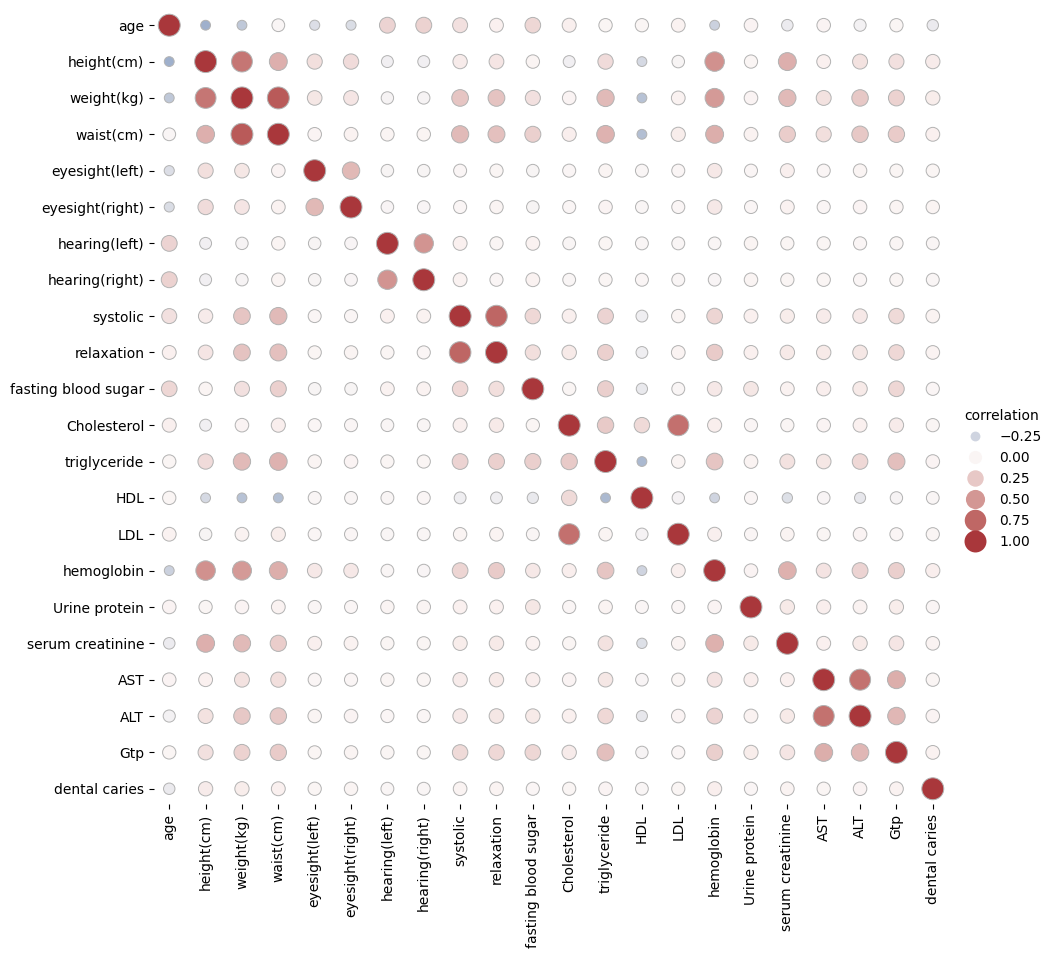

In [29]:
# 相关系数图

features_columns

# Compute a correlation matrix and convert to long-form
corr_mat = features_columns.corr().stack().reset_index(name="correlation")

corr_mat

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

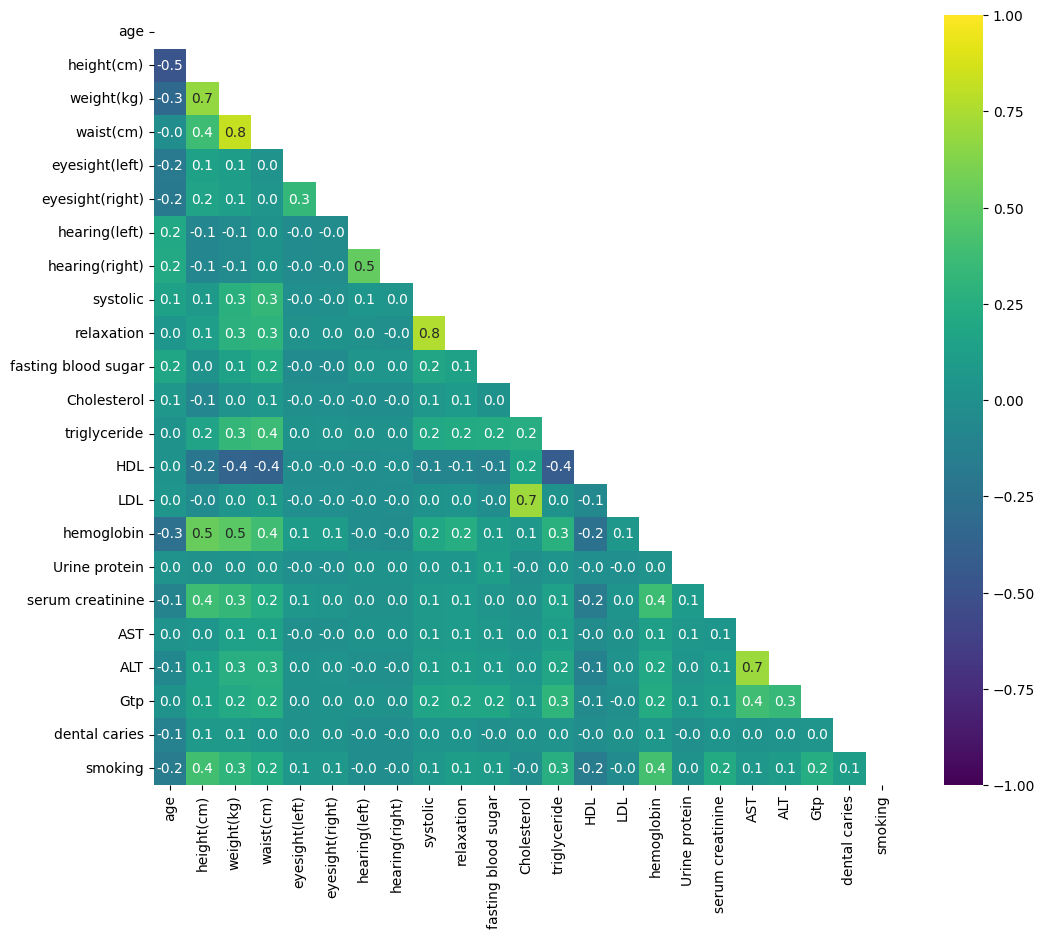

In [5]:
# 热力图绘制

mask = np.triu(np.ones_like(train.corr()))
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(),
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            center=0, mask=mask,
            cmap="viridis"
            )
plt.show()

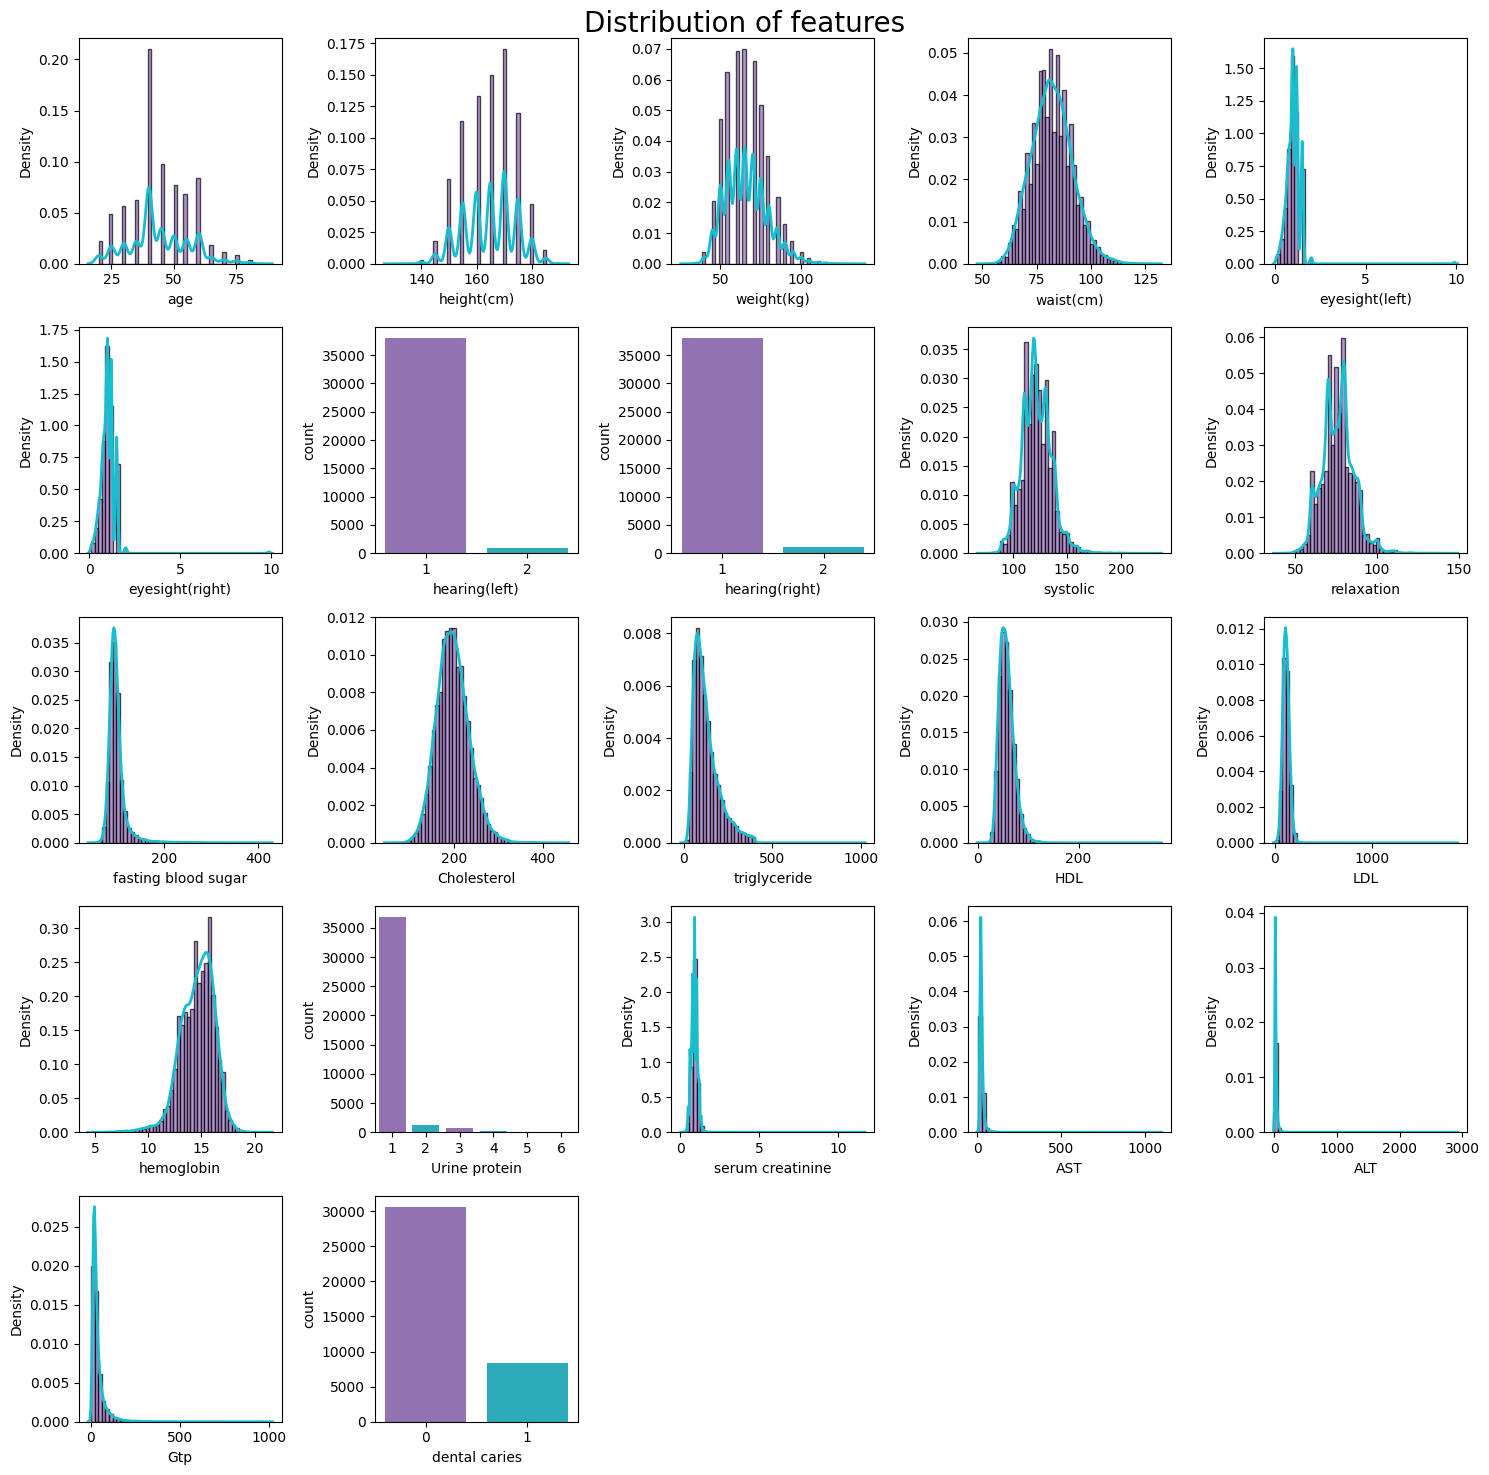

In [8]:
columns_to_plot = train.columns.drop(['smoking'])
palette = ['#9467bd', '#17becf']  # purple, cyan

# 计算行数和列数
num_rows = 5
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, column in enumerate(columns_to_plot):
    if i < num_rows*num_cols - 3:
        ax = axs[i // num_rows][i % num_cols]
        if train[column].nunique() <= 10:
            sns.countplot(x=column, data=train, ax=ax, palette=palette)
        else:
            # sns.histplot(train[column], ax=ax, color=palette[0],kde=True,kde_kws={"color":palette[1]})
            sns.distplot(train[column], color=palette[0], hist=True, kde=True, ax=ax,
                         hist_kws={"edgecolor": "black",
                                   "linewidth": 1, "alpha": 0.7},
                         kde_kws={"color": palette[1], "linewidth": 2})
    else:
        axs[i // num_cols][i % num_cols].axis('off')

# 添加大标题
fig.suptitle(f'Distribution of features', fontsize=20)

# 隐藏最后三个子图
for i in range(num_rows * num_cols - 3, num_rows * num_cols):
    axs.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

- Age Distribution: Fairly uniform with a slight decrease in older age groups.
- Height and Weight: Show a normal distribution.
- Waist Circumference: Right-skewed distribution, indicating that a higher proportion of the population has a waist size on the lower end of the scale.
- Eyesight Measurements: Show a peak around 1.0, which may indicate normal vision, but there are also a number of people with measurements much higher, possibly due to errors or special cases.
- Hearing Ability: Mostly '1', indicating that most people do not have hearing difficulties.
- Blood Pressure Readings (Systolic and Diastolic): Normal distribution with some outliers on the higher end.
- Blood Sugar Levels: Right-skewed, with some individuals having high fasting blood sugar levels.
- Cholesterol and Lipid Profiles (Triglycerides, HDL, LDL): Range of values with right-skewness in triglycerides, indicating some individuals have high levels.
- Hemoglobin Levels: Normally distributed.
- Urine Protein: A marker for kidney function, mostly shows normal levels ('1'), with a few higher values.
- Serum Creatinine: Another marker for kidney function, shows a normal distribution.
- Liver Function Tests (AST, ALT, and Gtp): Vary widely, with right-skewed distributions indicating some individuals with high values.
- Dental Caries Presence: Less common than its absence.

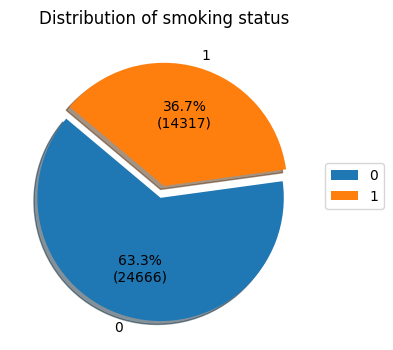

In [9]:
# 查看目标变量分布

Uniq_vals = train['smoking'].value_counts()

LABELS = ['0', '1']


def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(Uniq_vals,
       labels=LABELS,
       autopct=lambda pct: func(pct, Uniq_vals),
       shadow=True,
       explode=(0.1, 0),
       startangle=140)

ax.legend(loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Distribution of smoking status')
plt.show()

In [30]:
# 检查是否存在缺失值

train.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [11]:
# 数据的描述性统计

train.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,...,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,...,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,...,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [12]:
# 检查重复的行数

train.duplicated().sum()

5517

- There are no missing values in any of the columns.
- The id column, as expected, has a unique value for each record.
- The age of the patients ranges from 20 to 85 years.
- height(cm) ranges from 130 to 190 cm, and weight(kg) ranges from 35 to 130 kg.
- waist(cm) ranges widely, from 51 to 129 cm, indicating a diverse population in terms of body shape.
- Eyesight measurements vary, with some extreme values up to 9.9, which might be worth investigating as it could indicate data entry errors.
- Hearing is a binary variable, indicating normal hearing (1) or hearing difficulty (2).
- Blood pressure (systolic) ranges from 71 to 240, with relaxation (likely diastolic blood pressure) ranging from 40 to 146.
- Blood sugar levels (fasting blood sugar) have a wide range as well, with a maximum of 416, which suggests some patients may have diabetes.
- Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, and Gtp have wide ranges, indicating varying levels of these measurements among the patients.
- dental caries is a binary variable, indicating the presence (1) or absence (0) of dental cavities.
- The smoking column, which is our target variable, is also binary, with values indicating whether a patient is a smoker (1) or not (0).as_integer_ratio

# 特征工程 

In [13]:
# 删除重复行

train = train.drop_duplicates()

# Check for duplicate rows
train.duplicated().sum()

0

In [14]:
def create_features(df):
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']

    df['HDL-LDL Ratio'] = df['HDL'] / df['LDL']
    df["HDL-triglyceride Ratio"] = df["HDL"] / df["triglyceride"]
    df["LDL-triglyceride Ratio"] = df["LDL"] / df["triglyceride"]
    df["Liver Enzyme Ratio"] = df["AST"] / df["ALT"]
    return df


train = create_features(train)
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,Gtp,dental caries,smoking,BMI,HW_Ratio,HA_Ratio,HDL-LDL Ratio,HDL-triglyceride Ratio,LDL-triglyceride Ratio,Liver Enzyme Ratio
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,125,1,1,29.411765,1.752577,4.857143,0.492958,0.457516,0.928105,0.530435
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,30,1,0,35.918367,1.590909,8.750000,0.622807,0.554688,0.890625,0.760000
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,276,0,0,27.055151,1.802326,3.444444,0.508929,0.475000,0.933333,0.778571
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,36,0,0,29.384757,1.755319,3.666667,0.505495,0.125683,0.248634,0.888889
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,15,0,0,22.038567,2.037037,8.250000,0.510870,0.235000,0.460000,0.928571


In [15]:
# 分离变量

X = train.drop(['smoking'], axis=1)
y = train['smoking']

In [16]:
# 数据标准化

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 模型创建 

## 训练测试集划分

In [17]:
SEED = np.random.seed(44)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.22,
                                                    random_state=SEED,
                                                    shuffle=True)

print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape)
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)

X_train shape is  (26104, 29)
X_test shape is  (7363, 29)
y_train shape is  (26104,)
y_test shape is  (7363,)


## 超参数选择

In [ ]:
'''
# Create an Optuna objective function
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 750),
        'max_depth':  trial.suggest_int('max_depth', 3, 50),
        'min_child_weight': trial.suggest_float('min_child_weight', 2, 50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
        "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    
    # Build the xgboost model
    optuna_xgbmodel = XGBClassifier(**params,
                                    random_state=SEED,
                                    device="gpu",
                                    eval_metric= "auc")
    # Evaluate the model
    cv = cross_val_score(optuna_xgbmodel, X, y, cv = 4, scoring='roc_auc').mean()
    return cv

# Create the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=5000)
'''

## Xgboost

In [18]:
xgb_params = {'n_estimators': 550,
              'max_depth': 13,
              'min_child_weight': 6.751841929276507,
              'learning_rate': 0.025563726658688165,
              'subsample': 0.9554485347830493,
              'gamma': 0.5757672600044079,
              'colsample_bytree': 0.788439187144216,
              'colsample_bylevel': 0.6106452928321808,
              'colsample_bynode': 0.40013133896770514
              }
# Build the XGBoost model
XGBModel = XGBClassifier(**xgb_params,
                         random_state=SEED,
                         eval_metric='auc')

XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6106452928321808,
              colsample_bynode=0.40013133896770514,
              colsample_bytree=0.788439187144216, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.5757672600044079,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025563726658688165,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=6.751841929276507, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=550,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [19]:
# Evaluate a score by cross-validation
cross_val_score(XGBModel, X_train, y_train, scoring='roc_auc', cv=4).mean()

0.8274244379921136

### Xgboost模型评估

In [20]:
y_pred = XGBModel.predict(X_test)
y_pred_proba = XGBModel.predict_proba(X_test)[:, 1]
auc = np.round(roc_auc_score(y_test, y_pred), 3)
print(f' F1 Score : {f1_score(y_test, y_pred)}')
print(f'Classification Report: \n{classification_report(y_test, y_pred)}')

 F1 Score : 0.6638360716263615
Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      4605
           1       0.68      0.65      0.66      2758

    accuracy                           0.75      7363
   macro avg       0.74      0.73      0.73      7363
weighted avg       0.75      0.75      0.75      7363



In [ ]:
def plot_roc_curve(y_test, y_pred_proba):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='red', lw=2,
             label='Area under ROC curve = %0.2f' % auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve(y_test, y_pred_proba)

### 混淆矩阵

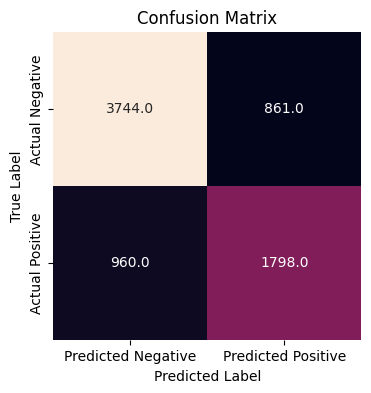

In [23]:
CM = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(CM,
            annot=True,
            fmt=".1f",
            square=True,
            cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## MLP

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score

num_features = len(train.drop(['smoking'], axis=1).columns.to_list())

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(num_features,)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1920      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2977 (11.63 KB)
Trainable params: 2977 (11.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, batch_size=512, epochs=100)

Epoch 1/100
51/51 [==============================] - 1s 4ms/step - loss: 0.6633 - auc: 0.5173
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.6186 - auc: 0.6719
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5857 - auc: 0.7217
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5634 - auc: 0.7477
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5497 - auc: 0.7613
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5366 - auc: 0.7757
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5307 - auc: 0.7804
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5239 - auc: 0.7875
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5224 - auc: 0.7891
Epoch 10/100
51/51 [==============================] - 0s 3ms/step - loss: 0.5174 - auc: 0.7923
Epoch 11/100
51/51 [==============================] - 0s 3m

## 随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
predRFC = RFC.predict(X_test)

In [ ]:
cross_val_score(RFC, X_train, y_train, scoring='roc_auc', cv=4).mean()

In [ ]:
print("Classification Report:", classification_report(y_test, predRFC))